# In this Notebook i analyze the model performance and visualize the results

The Visualization Questions can be found in the README.md

In [37]:
# imports
import torchinfo
import torch
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pathlib import Path
import models
import data_preprocessing as dp
import pytorch_lightning as pl

In [2]:
# Constants

BATCH_SIZE = 512
VERSION = "version_0"
QUANTILES = models.QUANTILES

# Load the models and the data

In [13]:
# load the the Quantile Model 
model_path = Path(f"./saves/{VERSION}/quantile_model")
quantile_model = models.create_quantile_model()
quantile_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


<All keys matched successfully>

In [14]:
# look how the model looks
torchinfo.summary(
    model=quantile_model, 
    input_size=[(BATCH_SIZE, ), (BATCH_SIZE, ), (BATCH_SIZE, ), (BATCH_SIZE, ), (BATCH_SIZE, 11)],
    dtypes=[torch.int64, torch.int64, torch.int64, torch.int64, torch.float],
)

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [512, 5, 1]               72
├─Embedding: 1-1                         [512, 9]                  81
├─Embedding: 1-2                         [512, 5]                  115
├─Embedding: 1-3                         [512, 12]                 4,392
├─Embedding: 1-4                         [512, 12]                 288
├─Linear: 1-5                            [512, 55]                 660
├─Sequential: 1-6                        [512, 40, 57]             --
│    └─Conv1d: 2-1                       [512, 10, 84]             110
│    └─BatchNorm1d: 2-2                  [512, 10, 84]             20
│    └─ReLU: 2-3                         [512, 10, 84]             --
│    └─Conv1d: 2-4                       [512, 20, 75]             2,020
│    └─BatchNorm1d: 2-5                  [512, 20, 75]             40
│    └─ReLU: 2-6                         [512, 20, 75]             --
│    

In [8]:
# Load the data
data = dp.prepare_data()
_, df_test, _ = models.get_df_splits(data)
dl_test = models.get_dataloader(df_test, shuffle=False)

# Evaluate the model performance on the test set and Inspect the Tensorboard Logs

In [15]:
trainer = pl.Trainer()
trainer.test(quantile_model, dataloaders=[dl_test])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing: 0it [00:00, ?it/s]

Test MSE: 0.025891005992889404
Test R2 Score: 0.9969277381896973
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          test              0.3654952943325043
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test': 0.3654952943325043}]

## Test Metric Evaluation 

We can see, that the model performance is pretty good:
- The MSE is pretty low, which indicated a good fit
- And the R^2 Score is also close to 1 which indicates a good regression model
- The Test metric output can be ignored, it is a pytorch-lightning internal thing, which i do not use.

## Inspect Tensorboard Logs

In [16]:
# inspect training process with tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs

# Plot Temperature over Time for each Station.

## Get DataFrames for Station 1 - 6

In [44]:
dfs = []
dls = []
for i in range(1, 7):
    df = df_test.query(f'station_id == "M{i}"').sort_values(by="time")
    dfs.append(df)
    dls.append(models.get_dataloader(df, shuffle=False))


## Generate Predictions

In [50]:
@dataclass
class PredictionLabelStore():
    """Helper Class to store information i need for plotting"""
    predictions: np.ndarray
    label: np.ndarray
    x_axis: np.ndarray

predictions = {}
for i, (dl, df) in enumerate(zip(dls, dfs)):
    preds = []
    labels = []
    for batch in dl:
        inp = batch[:-1:]
        y = batch[-1]
        pred = quantile_model(*inp)
        preds.append(pred.detach())
        labels.append(y)
    predictions[f"M{i + 1}"] = PredictionLabelStore(
        torch.cat(preds).numpy(),
        torch.cat(labels).numpy(),
        df.time.to_numpy()
    )

In [83]:
def time_plot(pls: PredictionLabelStore, plot_range, label):
    pp = pls.predictions[plot_range, 0].squeeze()
    lower = pls.predictions[plot_range, 1].squeeze()
    upper = pls.predictions[plot_range, 4].squeeze()
    tv = pls.label[plot_range]
    x_axis = pls.x_axis[plot_range]

    # Draw plot with error band and extra formatting to match seaborn style
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(x_axis, pp, label='prediction')
    ax.plot(x_axis, lower, color='tab:blue', alpha=0.1)
    ax.plot(x_axis, upper, color='tab:blue', alpha=0.1)
    ax.plot(x_axis, tv, label='True Value', color="tab:red", alpha=0.3)
    ax.fill_between(x_axis, lower, upper, alpha=0.2, color="tab:blue")
    ax.set_xlabel('time')
    ax.set_ylabel('Air Temperature')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    fig.suptitle(label)
    plt.show()

## Plots with uncertainty

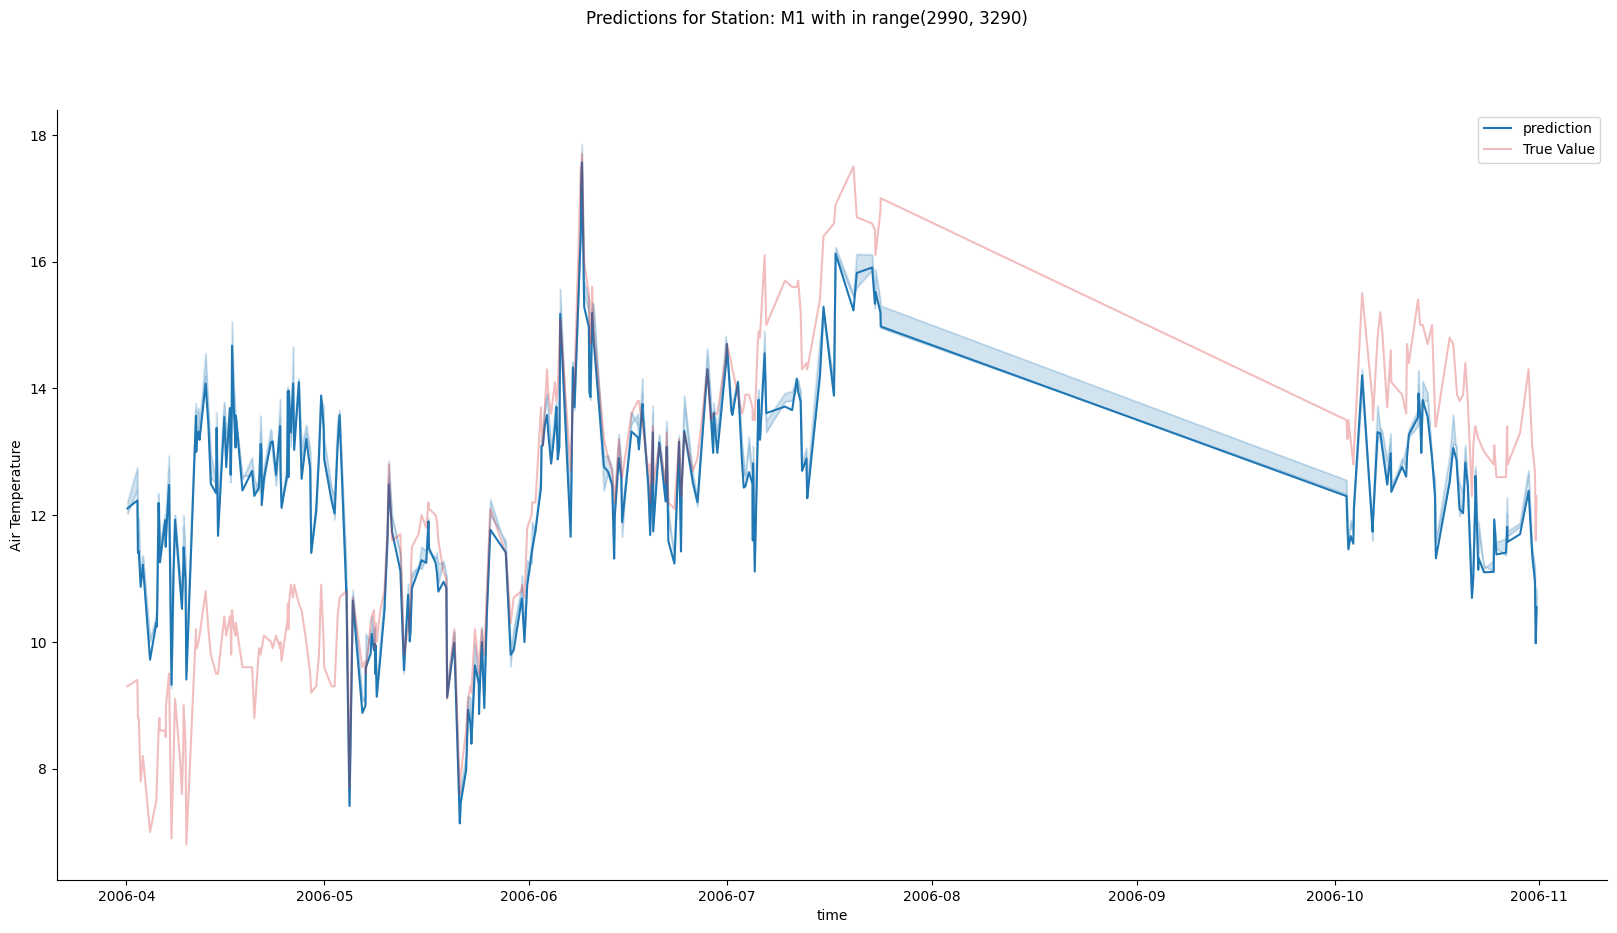

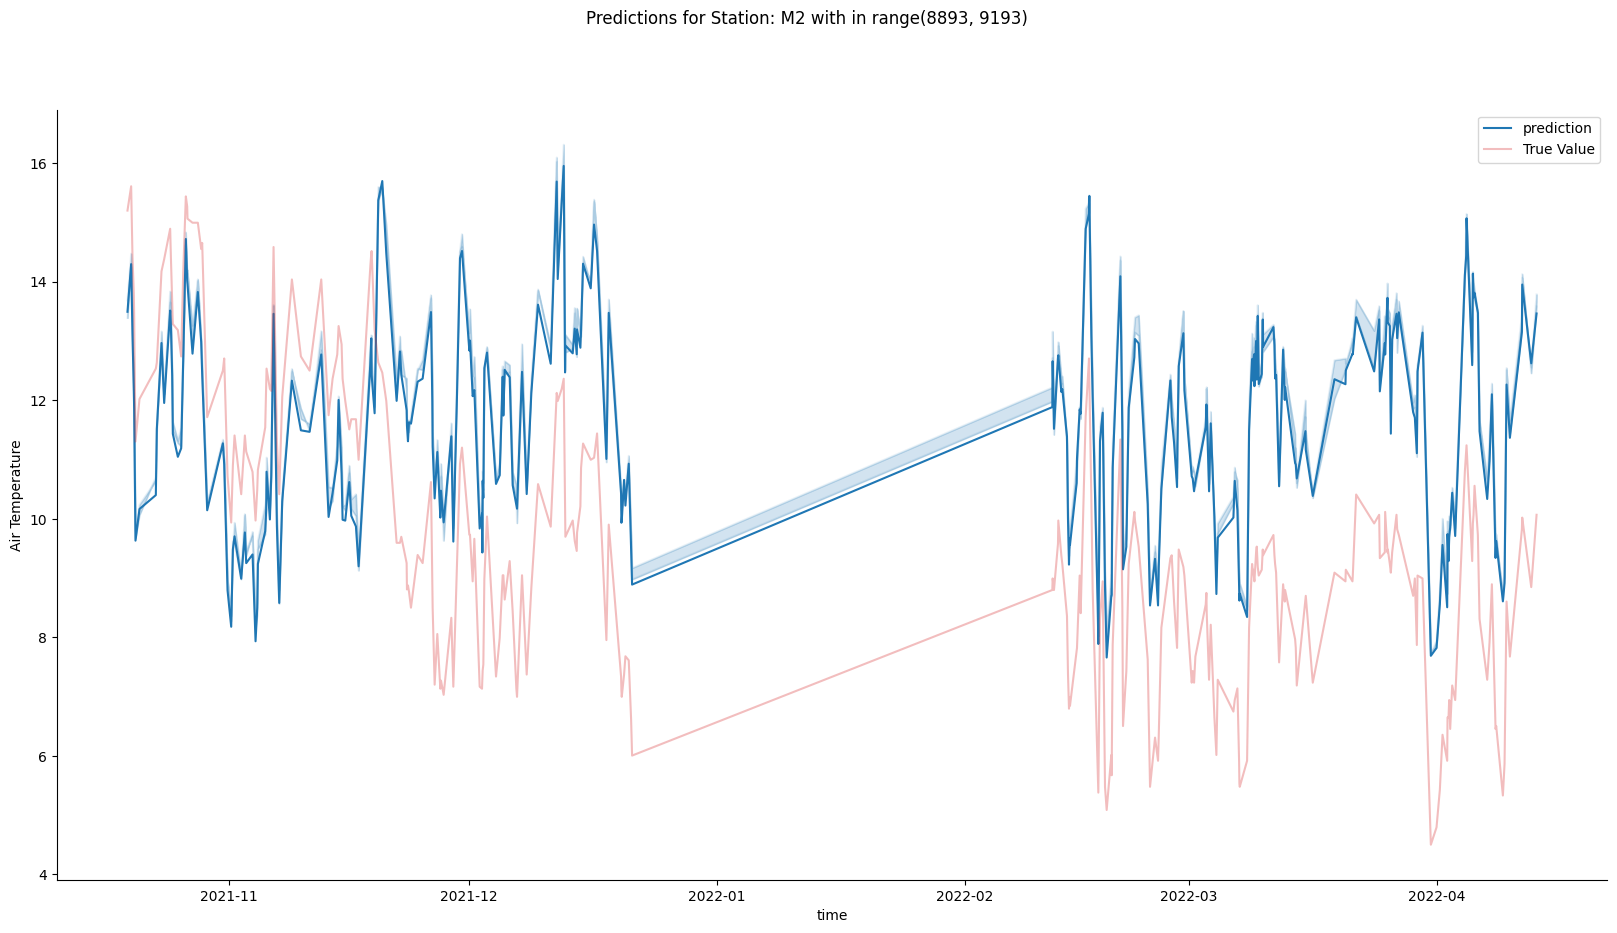

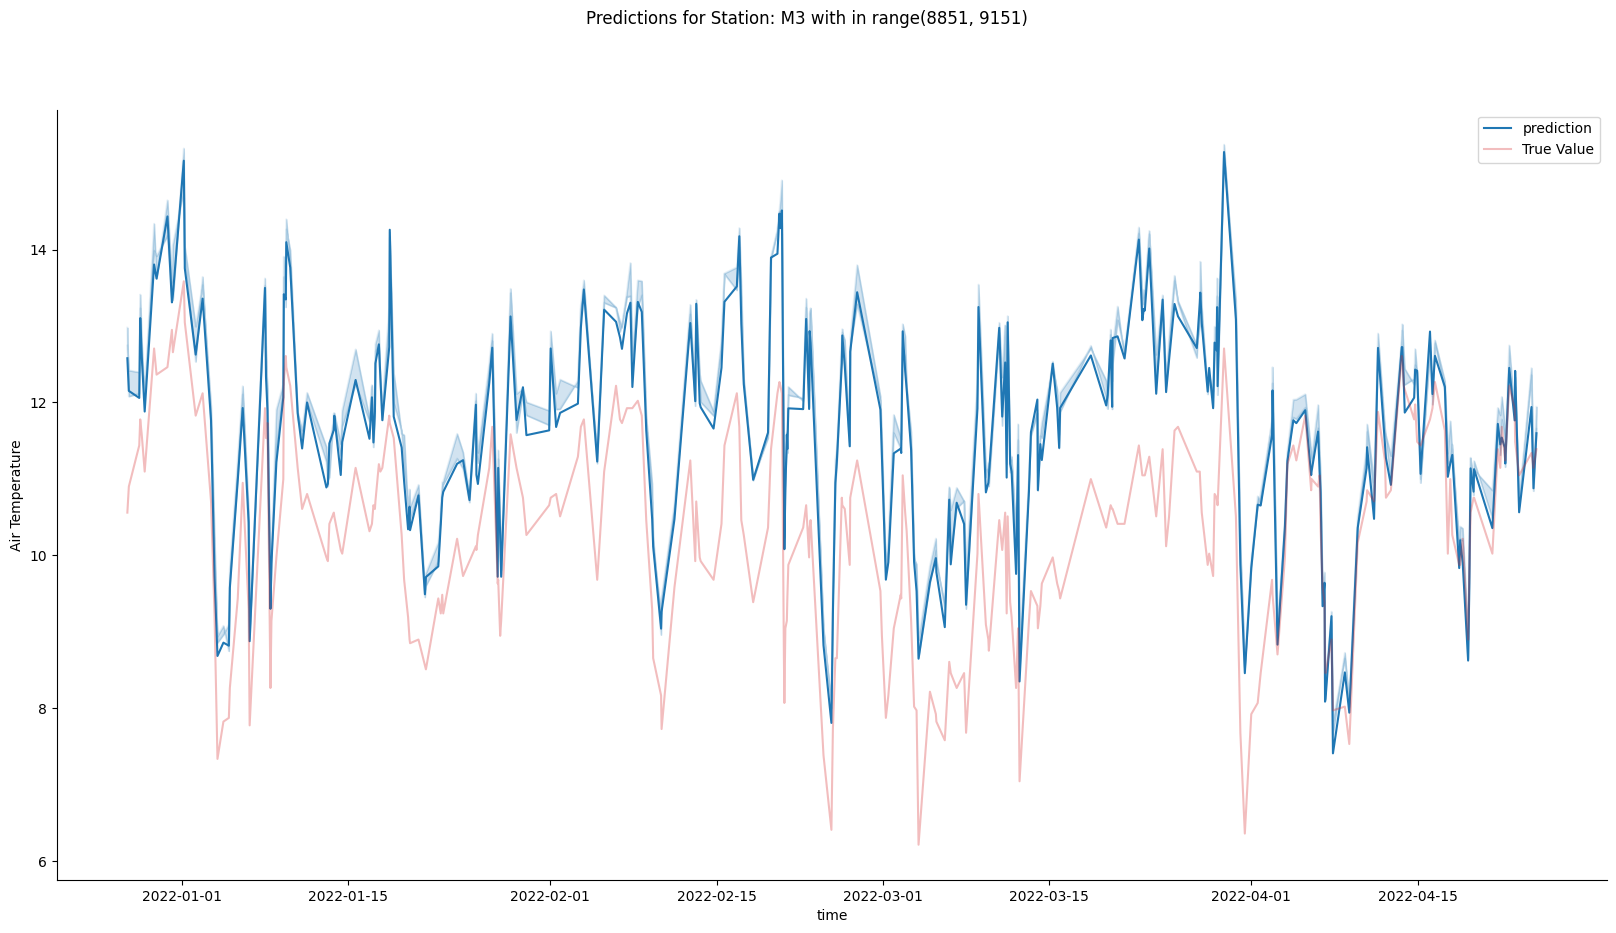

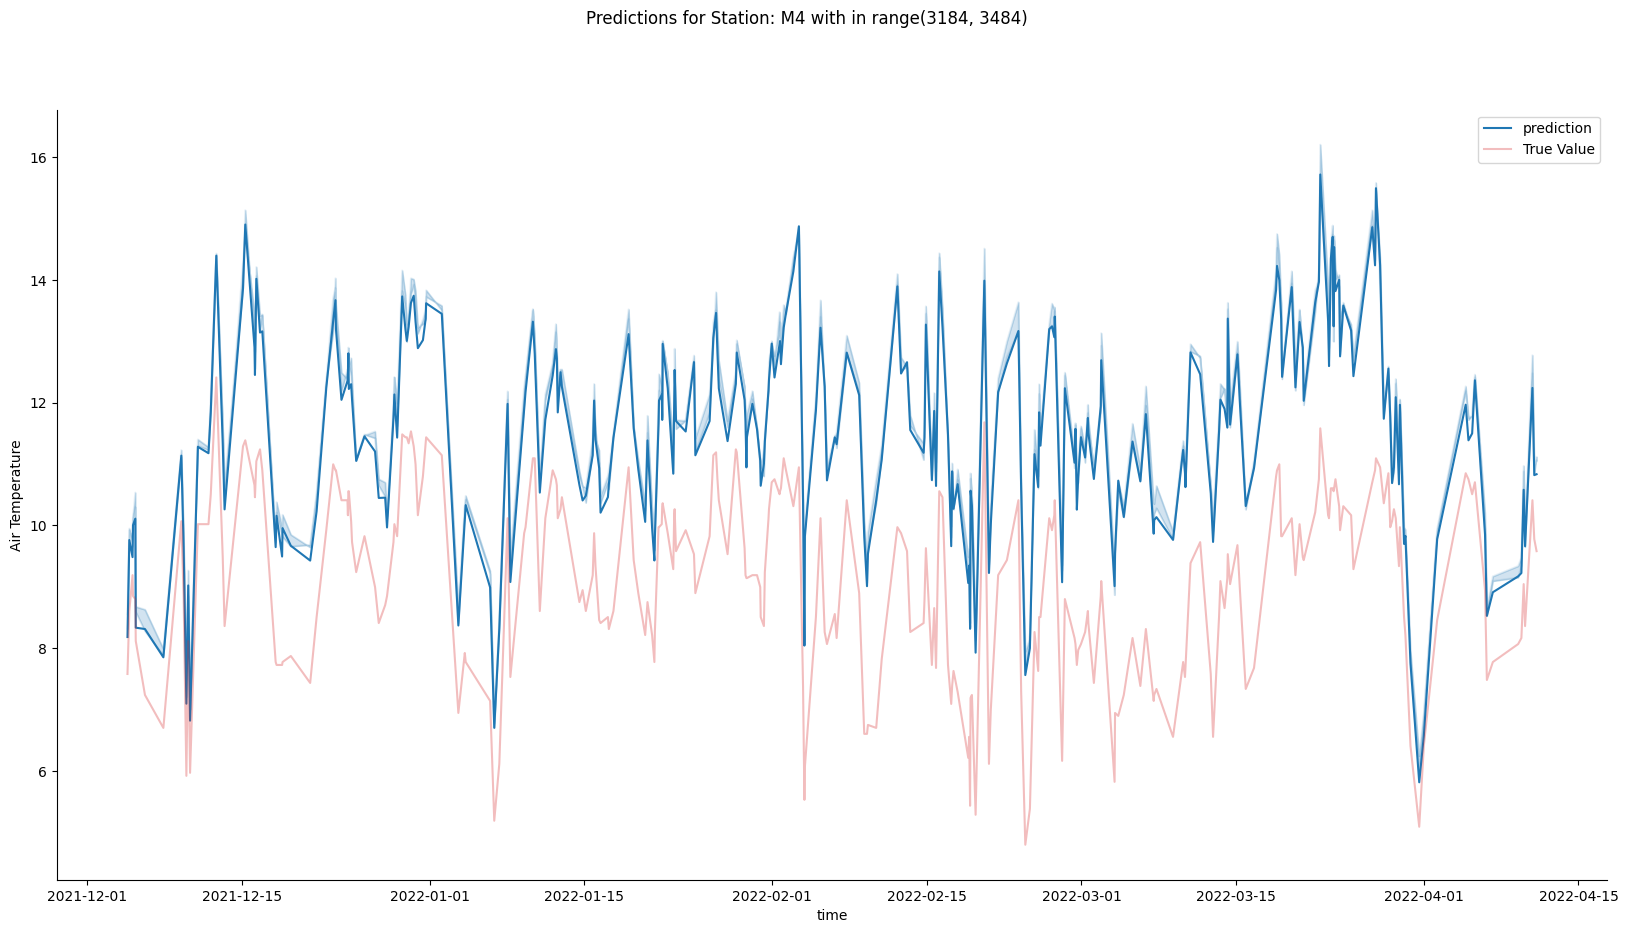

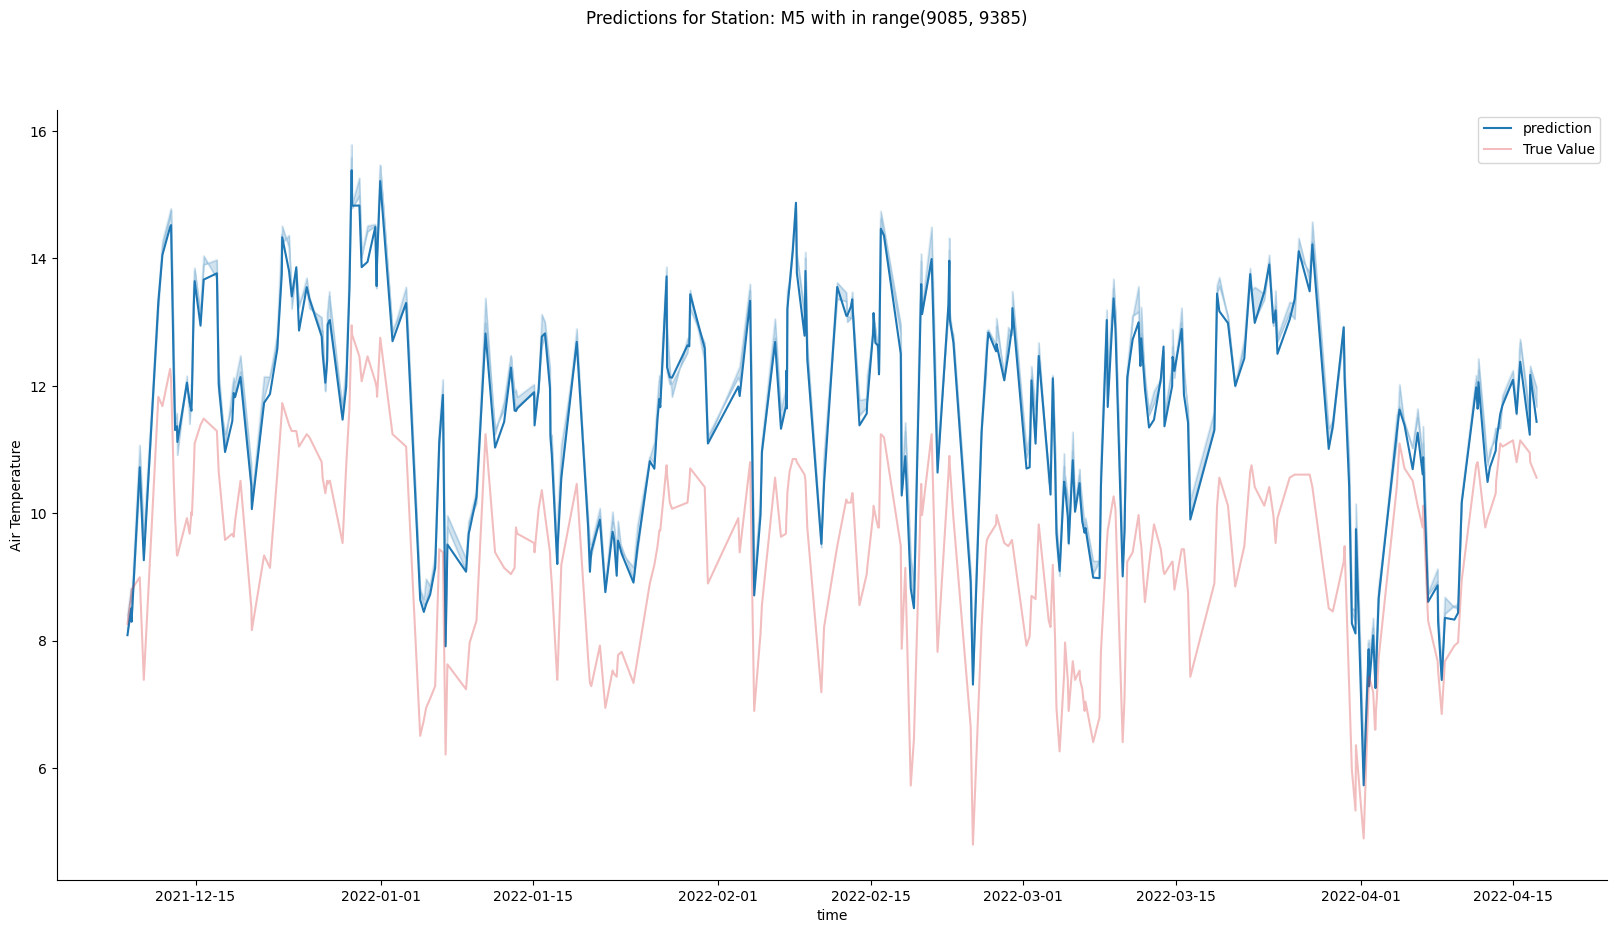

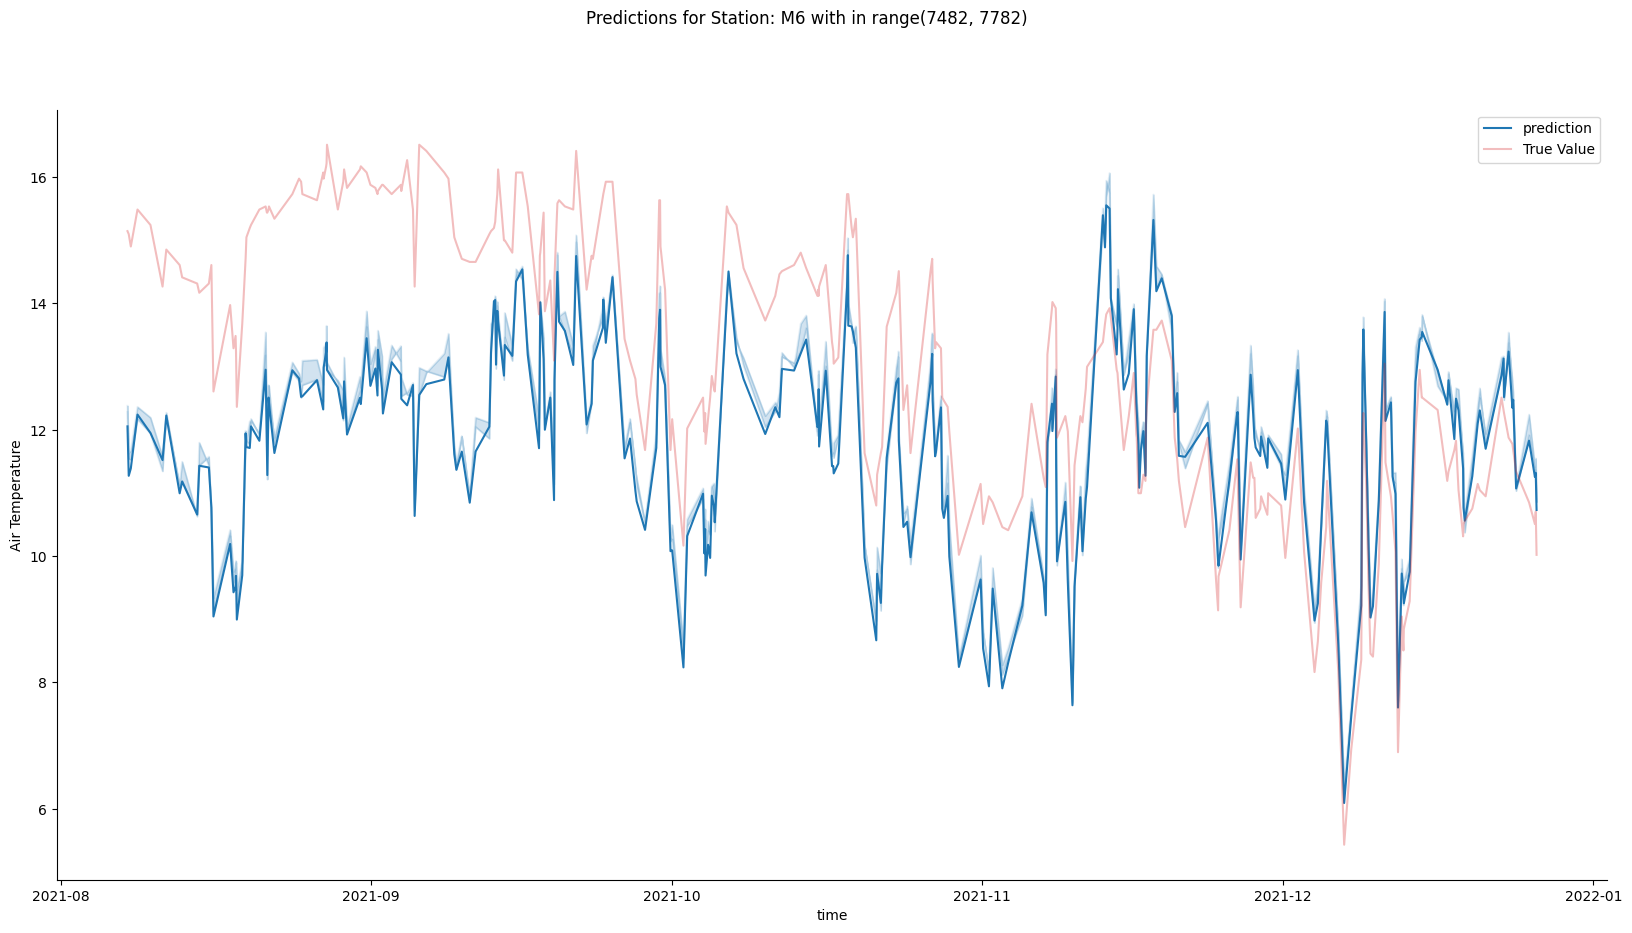

In [87]:
for station_id, pls in predictions.items():
    pls_length = pls.label.shape[0]
    plot_range = range(pls_length - 800, pls_length - 500)
    time_plot(pls, plot_range, f"Predictions for Station: {station_id} with in {plot_range}")


# Evaluation

- The Model Predictions suck! 
    - The Prediction Intervals do not surround the Predictions.
    - The Prediction and the True Values do not match.
- The Model Performance Metrics do not express that the model behaves badly